#### In the cell below please set path in which all csv files are stored with a '/' in the end. For eg. if files are stored in 'content' folder then path is 'content/'. 

The csv files are downloaded using the API of NY Times. API is called using the requests library in python. 

In [6]:
path = ''

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import re
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt


In [8]:
def author_split(authors_str, isbn):
    authors = re.split(' with | and ', str(authors_str))
    author_names = []
    for author in authors:
        name = author.split(" ",1)
        name.append('')
        author_names.append({'first_name': name[0], 'last_name': name[1], 'name': author, 'isbn': isbn})
    return author_names

1. Design a SQL or NoSQL database to capture this information.
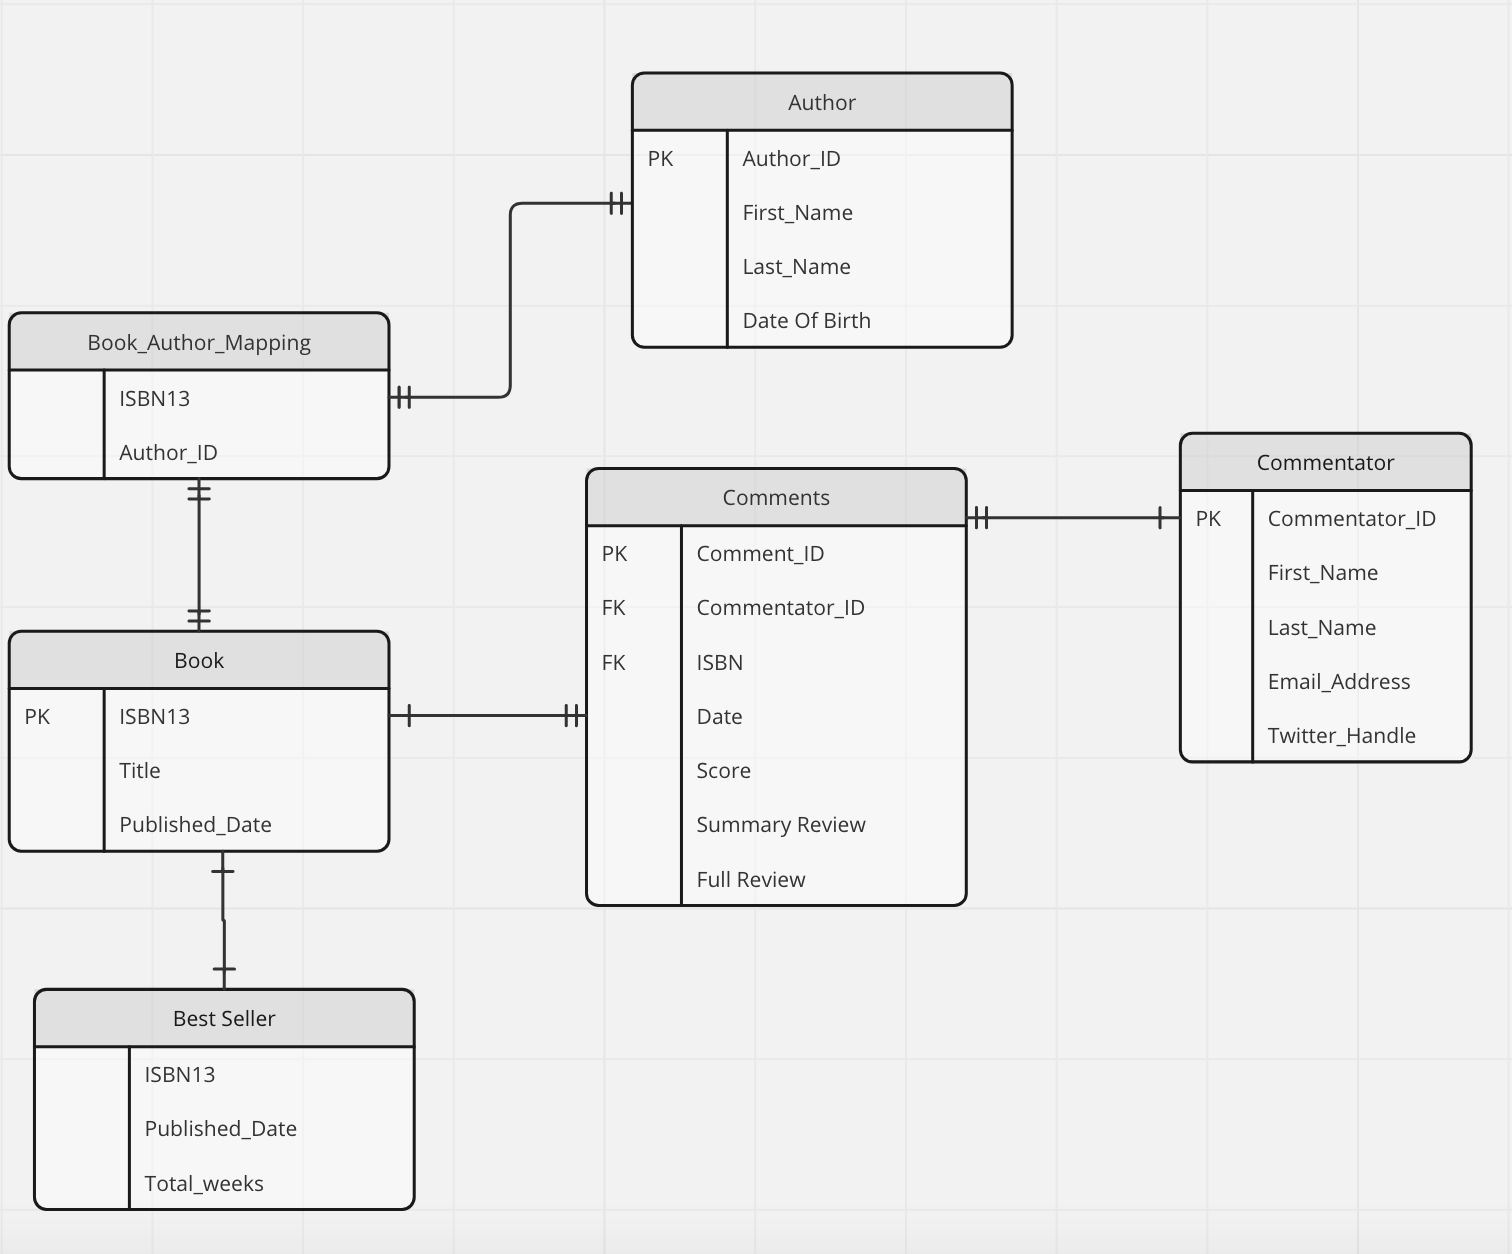

A range of years from 2012 to 2023 and reads a CSV file for each year. It adds the data from each file to the df_final table.



In [9]:
df_final = pd.DataFrame()
for i in range(2011, 2024):
  filename = 'best_seller' + str(i) + '.csv'
  df = pd.read_csv(path+filename)
  df_final = df_final.append(df)
df_final.head()

,published_date,rank,rank_last_week,weeks_on_list,asterisk,dagger,primary_isbn10,primary_isbn13,publisher,description,...,book_image_height,amazon_product_url,age_group,book_review_link,first_chapter_link,sunday_review_link,article_chapter_link,isbns,buy_links,book_uri
0,2011-12-25,1.0,0.0,1.0,0.0,0.0,0679603751,9780679603757,Random House,An Olympic runner’s story of survival as a pri...,...,400.0,http://www.amazon.com/Unbroken-World-Survival-...,NaN,https://www.nytimes.com/2010/11/15/books/15boo...,NaN,https://www.nytimes.com/2010/11/21/books/revie...,NaN,"[{'isbn10': '1400064163', 'isbn13': '978140006...","[{'name': 'Amazon', 'url': 'http://www.amazon....",nyt://book/8eab8215-dfc5-5137-8ef6-896cfbaa0b32
1,2011-12-25,2.0,0.0,1.0,0.0,0.0,0849946158,9780849946158,Thomas Nelson,A father recounts his 3-year-old son’s encount...,...,495.0,http://www.amazon.com/Heaven-Real-Little-Astou...,NaN,https://www.nytimes.com/2011/03/12/books/heave...,NaN,NaN,NaN,"[{'isbn10': '0849946158', 'isbn13': '978084994...","[{'name': 'Amazon', 'url': 'http://www.amazon....",nyt://book/8eea17d5-d79d-51e5-9f7f-8654146058cb
2,2011-12-25,3.0,0.0,1.0,0.0,0.0,1594202842,9781594202841,Penguin Group,A Chinese-American mother makes a case for str...,...,495.0,http://www.amazon.com/Battle-Hymn-Tiger-Mother...,NaN,https://www.nytimes.com/2011/01/20/books/20boo...,NaN,https://www.nytimes.com/2011/02/13/books/revie...,NaN,"[{'isbn10': '1594202842', 'isbn13': '978159420...","[{'name': 'Amazon', 'url': 'http://www.amazon....",nyt://book/f340db9d-6911-57c6-8e58-4e17d5ccfa1f
3,2011-12-25,4.0,0.0,1.0,0.0,0.0,0307590615,9780307590619,Crown,The former president’s memoir discusses his Ch...,...,280.0,http://www.amazon.com/Decision-Points-George-W...,NaN,https://www.nytimes.com/2010/11/04/books/04boo...,NaN,https://www.nytimes.com/2010/12/19/books/revie...,NaN,"[{'isbn10': '0307590615', 'isbn13': '978030759...","[{'name': 'Amazon', 'url': 'http://www.amazon....",nyt://book/02b81882-0b96-5909-8285-13f4f0914fac
4,2011-12-25,5.0,0.0,1.0,0.0,0.0,0307265633,9780307265630,Knopf Doubleday,A physicist explains various theories involvin...,...,495.0,http://www.amazon.com/The-Hidden-Reality-Paral...,NaN,https://www.nytimes.com/2011/01/27/books/27boo...,NaN,https://www.nytimes.com/2011/02/06/books/revie...,NaN,"[{'isbn10': '0307265633', 'isbn13': '978030726...","[{'name': 'Amazon', 'url': 'http://www.amazon....",nyt://book/a2ac5d49-2b86-5d62-bc2f-43bbcd565818


2. Write the code to create the necessary tables to store this information in a relational database, using any SQL or NoSQL dialect you prefer (e.g. MySQL PostgreSQL, MSSQL, etc.).

The code then connects to a database "BookIt" 

In [10]:
conn = sqlite3.connect('BookIt')
c = conn.cursor()

Stores information about books, including the title, ISBN (unique identifier), and publication date.

In [11]:
Book = 'CREATE TABLE IF NOT EXISTS Book(\
    Title VARCHAR(255),\
    ISBN VARCHAR(255) PRIMARY KEY,\
    Publication_Date TEXT\
    )'
c.execute(Book)
conn.commit()

df_final[['title', 'primary_isbn13', 'published_date']].to_sql('Book', conn, if_exists = 'replace', index = False)

11205

Author: Stores information about authors, including their first and last names, date of birth, and a unique author ID.

In [12]:
Author = 'CREATE TABLE IF NOT EXISTS Author(\
    First_Name VARCHAR(255),\
    Last_Name VARCHAR(255), \
    Date_Of_Birth DATE, \
    Author_Id INTEGER PRIMARY KEY AUTOINCREMENT\
)'
c.execute(Author)
conn.commit()

df_auth_isbn_series = df_final.apply(lambda x: author_split(x['author'], x['primary_isbn13']), axis=1)
df_authors_isbn = pd.DataFrame(list(df_auth_isbn_series.explode()))

df_authors = df_authors_isbn[['first_name', 'last_name']].drop_duplicates()
df_authors['DOB'] = np.nan
df_authors['Author_Id'] = list(range(1, len(df_authors)+1))

df_authors[['first_name', 'last_name', 'DOB', 'Author_Id']].to_sql('Author', conn, if_exists = 'replace', index = False)

1999

Book_Author_mapping: Represents the relationship between books and authors by linking the author ID with the book's ISBN.

In [13]:
Book_Author_mapping = 'CREATE TABLE IF NOT EXISTS Book_Author_mapping(\
    Author_id INT,\
    ISBN VARCHAR(255)\
)'
c.execute(Book_Author_mapping)
conn.commit()

Book_Author_m = pd.merge(df_authors, df_authors_isbn, on =['first_name', 'last_name'], how = 'inner').drop_duplicates()[['Author_Id', 'isbn']]
Book_Author_m.to_sql('Book_Author_mapping', conn, if_exists = 'replace', index = False)

3211

Commentator: Contains details about the commentators who provide book reviews, including their ID, first and last names, email address, and Twitter handle.

In [14]:
Commentator = "CREATE TABLE IF NOT EXISTS Commentator(\
    Commentator_Id INT,\
    First_Name VARCHAR(255),\
    Last_Name VARCHAR(255),\
    Email_Address VARCHAR(255),\
    Twitter_Handle VARCHAR(255),\
    PRIMARY KEY(Commentator_Id))"
c.execute(Commentator)
conn.commit()

# Commentator table data has to be inserted manually not available in API

Comments: Stores the actual comments provided by the commentators, including the comment ID, commentator ID (linked to the Commentator table), book's ISBN (linked to the Book table), comment date, score, summary review, and full review.

In [15]:
Comments = "CREATE TABLE IF NOT EXISTS Comments(\
    Comment_Id INT,\
    Commentator_Id INT,\
    ISBN VARCHAR(255),\
    Comment_Date DATE,\
    Score INT,\
    Summary_Review TEXT,\
    Full_Review TEXT,\
    PRIMARY KEY(Comment_Id)\
    FOREIGN KEY (Commentator_Id) REFERENCES Commentator(Commentator_Id),\
    FOREIGN KEY (ISBN) REFERENCES Book(ISBN)\
)"
c.execute(Comments)
conn.commit()

# Comments  table data has to be inserted manually not available in API

Best_Sellers: Tracks information about best-selling books, including the book's ISBN, the date it was published, and the total number of weeks it has been a best seller.


In [16]:
Best_Sellers = "CREATE TABLE IF NOT EXISTS Best_Sellers(\
    ISBN VARCHAR(255),\
    Published_Date DATE,\
    Total_Weeks INT)"
c.execute(Best_Sellers)
conn.commit()

df_final[['primary_isbn13', 'published_date', 'weeks_on_list']].to_sql('Best_Sellers', conn, if_exists = 'replace', index = False)

11205

4. Using SQL or NoSQL, write code to retrieve a list of all books that were published after January 1st, 2020.

In [17]:
list_of_books_after_2020 = '''
SELECT DISTINCT title
FROM Book 
WHERE published_date >= '2020-01-01'
'''

sql_query = pd.read_sql_query (list_of_books_after_2020, conn)

df_books_after_2020 = pd.DataFrame(sql_query)
df_books_after_2020

,title
0,EDUCATED
1,BECOMING
2,TALKING TO STRANGERS
3,ME
4,SAM HOUSTON AND THE ALAMO AVENGERS
...,...
565,THE ESCAPE ARTIST
566,TELL ME EVERYTHING
567,THE STORY OF ART WITHOUT MEN
568,THE DADDY DIARIES


Using the language of your choice1, visualize the data in Step 4 to show counts of books by year published.

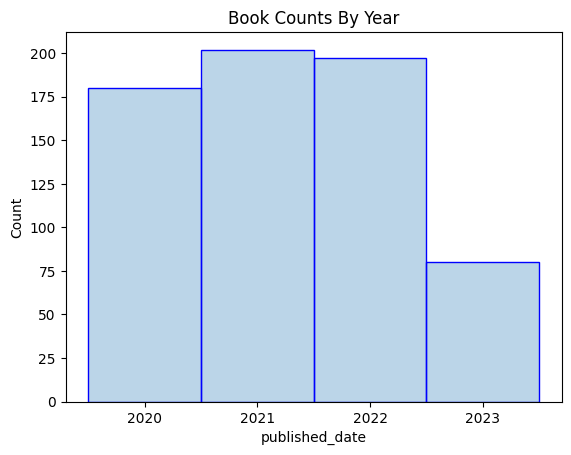

In [26]:
list_of_books_after_2020 = '''
SELECT DISTINCT title, published_date
FROM Book 
WHERE published_date >= '2020-01-01'
'''

sql_query = pd.read_sql_query (list_of_books_after_2020, conn)

df_books_after_2020 = pd.DataFrame(sql_query)
df_books_after_2020['published_date'] = df_books_after_2020['published_date'].str[:4]
df_books_after_2020 = df_books_after_2020.drop_duplicates()

sns.histplot(data=df_books_after_2020, x="published_date", alpha = .3, edgecolor = 'Blue').set(title='Book Counts By Year')
plt.show()

5. Using the language of your choice, write code to retrieve a list of all books who’ve been on the best selling list for 10 weeks or more and calculate the total number of weeks a book has made an appearance. The appearance does not have to be consecutive. <br>
 Using the language of your choice, visualize the data in Step 5 to show a histogram of book counts by how long they’ve been on the best seller list.

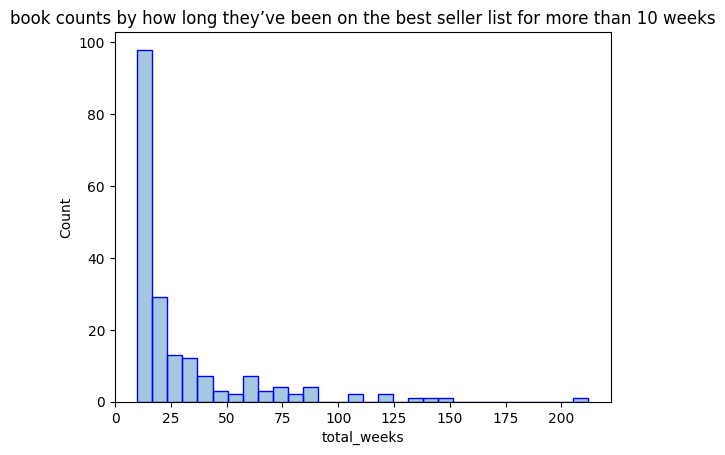

In [30]:
values = '''SELECT Book.title, Best_Sellers.published_date, max(Best_Sellers.weeks_on_list) as \'total_weeks\'
from Best_Sellers 
join Book
on Book.primary_isbn13 = Best_Sellers.primary_isbn13
group by Book.title
having total_weeks >= 10
'''

sql_query = pd.read_sql_query (values, conn)

df_weeks_more_than_10 = pd.DataFrame(sql_query)

sns.histplot(data=df_weeks_more_than_10, x="total_weeks", alpha = .4, edgecolor = 'Blue')\
.set(title='book counts by how long they’ve been on the best seller list for more than 10 weeks')
plt.show()

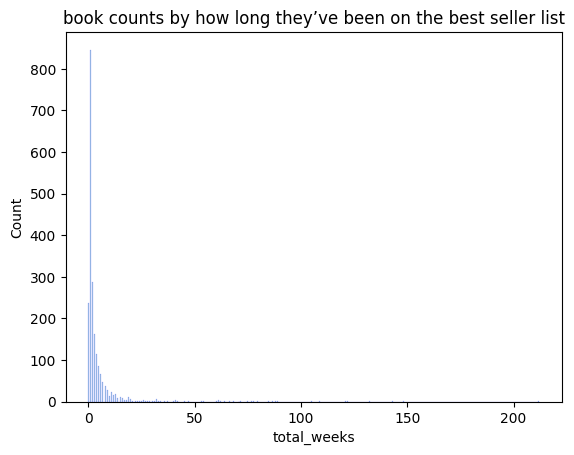

In [31]:
values = '''SELECT Book.title, Best_Sellers.published_date, max(Best_Sellers.weeks_on_list) as \'total_weeks\'
from Best_Sellers 
join Book
on Book.primary_isbn13 = Best_Sellers.primary_isbn13
group by Book.title
'''
sql_query = pd.read_sql_query(values, conn)

df_number_of_weeks = pd.DataFrame(sql_query)

sns.histplot(data=df_number_of_weeks, x="total_weeks", alpha = .4, edgecolor = 'Blue').set(title='book counts by how long they’ve been on the best seller list')
plt.show()

6. Build or describe a process for validating the database for any missing entries.

In [22]:
query_for_all_table_name = 'select name from sqlite_master where type=\'table\''

df_for_all_table_name =  pd.read_sql_query(query_for_all_table_name, conn)

for i in df_for_all_table_name['name']:

  if i != 'sqlite_sequence':

    q = 'SELECT * FROM '+i
    df_temp =  pd.read_sql_query(q, conn)

    print('Table', i)
    print(df_temp.isnull().sum())
    print()

Table Book
title              0
primary_isbn13     0
published_date    35
dtype: int64

Table Author
first_name       0
last_name        0
DOB           1999
Author_Id        0
dtype: int64

Table Book_Author_mapping
Author_Id    0
isbn         0
dtype: int64

Table Commentator
Commentator_Id    0.0
First_Name        0.0
Last_Name         0.0
Email_Address     0.0
Twitter_Handle    0.0
dtype: float64

Table Comments
Comment_Id        0.0
Commentator_Id    0.0
ISBN              0.0
Comment_Date      0.0
Score             0.0
Summary_Review    0.0
Full_Review       0.0
dtype: float64

Table Best_Sellers
primary_isbn13     0
published_date    35
weeks_on_list      0
dtype: int64

